In [117]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import _canoeValues as cv

#-------------------Inputs-------------------------------------------------------------
script = "Longitudinal Analysis_6 Paddler.ipynb"
input_file = "Station Information.csv"
outerHull_file = "Outer Hull.csv" # Will be used for hydrostatic force and waterline calculation
DLF = cv.DLF # Dead Load Factor
LLF = 1.5 # Live Load Factor
pad_weights = cv.pad_weights # Weight of paddlers (kg)
water_den = cv.water_density # Density of water = 1000 kg/m^3

# Acquire the waterline from grasshopper
grasshopper = cv.grasshopper[3] # [mm]

#--------------------------------------------------------------------------------------

script_dir = os.path.abspath('data')# absolute file path in Jupyter
file_path = os.path.join(script_dir, input_file) # file path for the text file input

# Get the canoe's volume and mass from the station info
canoe_info = pd.read_csv(file_path, header=None)
statVol = canoe_info[1][1:]
statMass = canoe_info[2]

# Get the outer hull coordinates from the input file
file_path = os.path.join(script_dir, outerHull_file) # file path for the text file input
out_coor = pd.read_csv(file_path, header=None)
x_out = out_coor[0]
y_out = out_coor[1]
z_out = out_coor[2]

#--------------------------------------------------------------------------------------

# First 3 force locations
pad_po = [1100, 1950, 2495]

canoe_len = round(max(x_out))
pad_po += [canoe_len - x for x in pad_po]



pad_weight = [pad_weights[1] * LLF] * 6


#--------------------------------------------------------------------------------------

# Convert Series to List
# Get the mass and volume at each station from the Station Information csv file (exported from Approximation-Vol Diff)
stat_Mass = []
for i in range(1,len(statMass),1):
    stat_Mass.append(float(statMass[i]))

stat_Vol = []
for i in range(1,len(statVol),1):
    stat_Vol.append(float(statVol[i]))

canoe_volume = np.sum(stat_Vol) # m^3
canoe_weight = np.sum(stat_Mass) #[kg]
total_weight = canoe_weight*DLF + sum(pad_weight) #[kg]

station_no = x_out.nunique() # number of stations
station = x_out.unique() # location of each station

print(station_no)
print(station)

57
[   0.        100.892857  201.785714  302.678571  403.571429  504.464286
  605.357143  706.25      807.142857  908.035714 1008.928571 1109.821429
 1210.714286 1311.607143 1412.5      1513.392857 1614.285714 1715.178571
 1816.071429 1916.964286 2017.857143 2118.75     2219.642857 2320.535714
 2421.428571 2522.321429 2623.214286 2724.107143 2826.       2925.892857
 3026.785714 3127.678571 3228.571429 3329.464286 3430.357143 3531.25
 3632.142857 3733.035714 3833.928571 3934.821429 4035.714286 4136.607143
 4237.5      4338.392857 4439.285714 4540.178571 4641.071429 4741.964286
 4842.857143 4943.75     5044.642857 5145.535714 5246.428571 5347.321429
 5448.214286 5549.107143 5650.      ]


In [118]:
# NOTE: Very similar to above code cell. Will update accordingly after reviewing above cell with Kielen.

# Outer Hull Volume
vol_out = []

# Loop through each station
# The loop ends at station_no - 2 because each loop uses the kth and the (k+1)th station
# Starts at 1 to skip 0,0,0
for k in range(1,station_no-2):

    # Coordinates of points in the outer frame sharing an X-coordinate with the current (k) station
    X1_value = station[k]
    Y1 = []
    Z1 = []

    # Coordinates of points in the outer frame sharing an X-coordinate with the next (k+1) station
    X2_value = station[k+1]
    Y2 = []
    Z2 = []

    # Loop through each x coordinate in the outer hull
    for i in range(0,len(x_out)):
        
        # Check if the X-coordinate is equal to the X-coordinate of the *first* station
        # If true, save each coordinate component (XYZ)
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])

        # If the above statement doesn't apply, check if the X-coordinate is equal to that of the *second* station
        # If true, save each coordinate component (XYZ)
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    
    #Volume Calculation
    volume = 0
    # Only perform ___ if there is a point on the currently 
    # NOTE: Explain loop, only loops through half of the points found? <?>
    if len(Y1)/2 == 0:
        n = int(len(Y1)/2)
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
    else:
        n = (len(Y1)-1)//2
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        # triangle piece at the bottom
        area1 = abs(Y1[n-1])*abs(Z1[n] - Z1[n-1])/2*2
        area2 = abs(Y2[n-1])*abs(Z2[n] - Z2[n-1])/2*2
        volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        vol_out.append(volume)

#Outer Volume Calculation (This is what this section of code outputs)
outer_volume = np.sum(vol_out)/10**9 #[m^3]
print(outer_volume)

0.7992452801986238


In [119]:
canoe_depth = max(abs(z_out)) 
waterline = canoe_depth - grasshopper # distance from the water surface to the bottom of canoe [mm]
increment = 1 # push down waterline by [] mm
water_weight = outer_volume*water_den # Assume canoe is fully submerged in water

#while water_weight - total_weight > 10:
vol_out = []
for k in range(1,station_no-2,1):
    X1_value = station[k]
    X2_value = station[k+1]
    Y1 = []
    Y2 = []
    Z1 = []
    Z2 = []

    # For loop that checks all canoe X-coordinates for the statements below (in green)
    for i in range(0,len(x_out),1):

        #Check if the canoe depth subtracted by a saved Z-coordinate is less than or equal to the waterline
        if canoe_depth - abs(z_out[i]) <= waterline:
            
            # If so, check if the X-coordinate (from the "for loop" above) is equal to the current station X-coordinate
            # If so, store this XYZ coordinate
            if x_out[i] == X1_value:
                Y1.append(y_out[i])
                Z1.append(z_out[i])
            
            # If the above statement is false, check if the same X-coordinate is equal to the next station X-coordinate
            # If so, store this XYZ coordinate
            elif x_out[i] == X2_value:
                Y2.append(y_out[i])
                Z2.append(z_out[i])
    
    # Inserting various values throughout the saved coordinate lists (for the most part, ignore)
    Y1.insert(0, Y1[0])
    Y1.append(Y1[len(Y1)-1])
    Z1.insert(0, waterline - canoe_depth)
    Z1.append(waterline - canoe_depth)
    
    Y2.insert(0, Y2[0])
    Y2.append(Y2[len(Y2)-1])
    Z2.insert(0, waterline - canoe_depth)
    Z2.append(waterline - canoe_depth)
    
    # Volume Calculations
    volume = 0
    if len(Y1)/2 == 0:
        n = int(len(Y1)/2)
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
    else:
        n = (len(Y1)-1)//2
        for j in range(0,n,1):
            area1 = (abs(Y1[j])+abs(Y1[j+1]))*abs(Z1[j]-Z1[j+1])/2*2
            area2 = (abs(Y2[j])+abs(Y2[j+1]))*abs(Z2[j]-Z2[j+1])/2*2
            volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        # triangle piece at the bottom
        area1 = abs(Y1[n-1])*abs(Z1[n] - Z1[n-1])/2*2
        area2 = abs(Y2[n-1])*abs(Z2[n] - Z2[n-1])/2*2
        volume = volume + abs(X1_value - X2_value)*(area1 + area2)/2
        vol_out.append(volume)


# From here down to calculating water_volume is doing the same thing as the loop above for the very ends of the canoe (which are calculated seperately)
# I added these into the loop in Approximation-Vol Diff to save the confusion. I'll do the same here when I find time, you can ignore the rest of these lines down until the water_volume calculation
# Volumes of decks
X1_value = station[0]
X2_value = station[0+1]
Y1 = []
Y2 = []
Z1 = []
Z2 = []

# Double checking for X-coordinate equalities between stations and saving values
for i in range(0,len(x_out),1):
    if x_out[i] == X1_value:
        Y1.append(y_out[i])
        Z1.append(z_out[i])

    if canoe_depth - abs(z_out[i]) <= waterline:
        if x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])

# Length, width, and height of saved coordinates for volume calculations
l = abs(max(Y2)-min(Y2))
w = abs(max(Z2)-min(Z2))
h = abs(X2_value - X1_value)

# Actual volume calculation occurs here
volume = l*w*h/3
vol_out.insert(0, volume)

#Reininitalizing / clearing arrays
X1_value = station[len(station)-1]
X2_value = station[len(station)-2]
Y1 = []
Y2 = []
Z1 = []
Z2 = []

# Repeating the same calculations as above???? I see no difference. Why can't we group these together with the ones above?
for i in range(0,len(x_out),1):
    if x_out[i] == X1_value:
        Y1.append(y_out[i])
        Z1.append(z_out[i])
        
    if canoe_depth - abs(z_out[i]) <= waterline:
        if x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])

#Calculates the volume of water using the saved coordinates above
l = abs(max(Y2)-min(Y2))
w = abs(max(Z2)-min(Z2))
h = abs(X2_value - X1_value)
volume = l*w*h/3
vol_out.append(volume)

#Combines the calculated water volumes above into a total water volume
water_volume = np.sum(vol_out)/10**9 #[m^3]
water_weight = water_volume*water_den
    
    #waterline = waterline - increment

# Output for this section of code
print('The depth of water is ', waterline, ' mm.')
print('The waterline is at', canoe_depth-waterline, 'mm.')
print('The weight of water is ', water_weight, 'kg.')
print('The total weight is ', total_weight, 'kg.')

The depth of water is  456.0  mm.
The waterline is at -100.0 mm.
The weight of water is  977.6719629380424 kg.
The total weight is  879.2403837834026 kg.


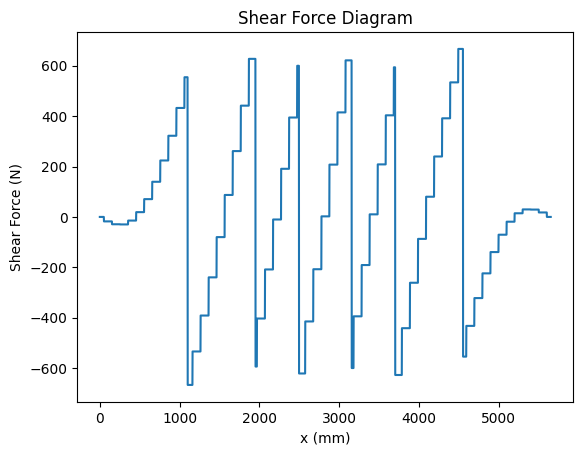

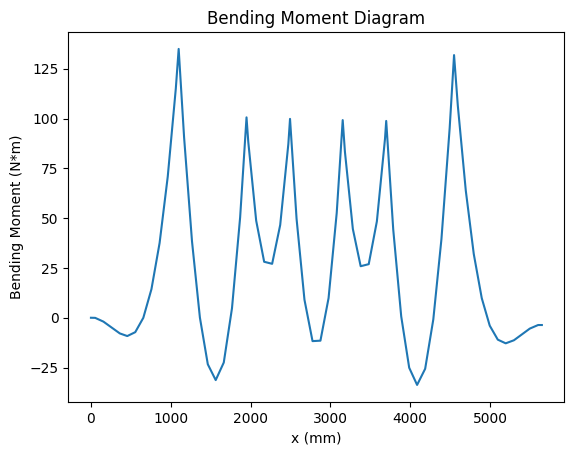

Maximum positive shear is  666.855009760035 N.
Maximum negative shear is  -666.855009760032 N.
Maximum positive moment is  134.94673884892555 Nm.
Maximum negative moment is  -33.71747894359951 Nm.
Moment at the end is  -3.6487818607284535 Nm.


In [120]:
difference = water_weight - total_weight
mass_out = []

# Looping for the number of saved values for the outer hull volume array (list)
# Calculate the mass for each iteration stored value in the array
# Store each of these mass values in a separate array (list) called "mass_out"
for i in range(0,len(vol_out)):
    mass = (vol_out[i]/10**9)*water_den - difference/len(vol_out)
    mass_out.append(mass)
    
# Plot SFD and BMD

# Length is equal to the X-coordinate of the station with the largest X-coordinate. Obtained from previous sections of code
length = max(x_out)


# Make an array containing the middle x-coordinate of each station
stat_x = []
for i in range(0,len(station)-1):
    stat_x.append((station[i]+station[i+1])/2)

# Calculate the shear force
g = 9.81
x = []
shear = []

# Loop through the length of the canoe
for i in range(0,int(length),1):
    
    # Append (add to the end of a list) the current distance travelled along the length of the canoe onto x
    x.append(i)

    # Calculate the shear force for this station
    shear_force = 0

    # Loop through each station
    for j in range(0,len(stat_x),1):
        # For each station we have moved past along the length of the canoe, sum up their impact on the shear force
        if i >= stat_x[j]:
            shear_force  = shear_force + mass_out[j]*g +(-1)*stat_Mass[j]*g*DLF
        
        # Why is this else statement even here? (reluctant to remove unless it has some hidden purpose I'm missing)
        else:
            shear_force = shear_force
    
    # Loop through each paddler (why is there no upper bound at 1 here?)
    for k in range(0,len(pad_po)):
        if i >= pad_po[k]:
            shear_force = shear_force - pad_weight[k]*g
        else:
            shear_force = shear_force
    
    # Append the shear force summed at this length along the canoe
    shear.append(shear_force)

plt.plot(x,shear)
plt.title('Shear Force Diagram')
plt.xlabel('x (mm)')
plt.ylabel('Shear Force (N)')
plt.show()

# Track mm distance of station for paddler positions
mm_traveled = 0
paddler_counter = 0

# Store Vf and paddlers? for csv file
Paddler_array = []
Station_by_length = []

for i in range(1,station_no):

    # Check if a paddler is in this station and calculate accordingly
    stationHasPaddler = False
    
    delta_mm_traveled = mm_traveled + float(canoe_info[4][i])

    # Any distance between the distance travlled (rounded) and the new distance travelled (larger due to more paddlers) (also rounded) will be saved. Anything else is discarded
    for j in range(round(mm_traveled), round(delta_mm_traveled)):
        Station_by_length.append(i)

    if(paddler_counter < len(pad_po)) and (mm_traveled <= pad_po[paddler_counter] and delta_mm_traveled > pad_po[paddler_counter]):
        stationHasPaddler = True
        paddler_counter += 1
    mm_traveled = delta_mm_traveled

    Paddler_array.append(stationHasPaddler)

# Export points to csv file:
df1 = pd.DataFrame(data={'Station': Station_by_length, 'Length': x, 'Shear': shear})

csv_file = 'Length_vs_Shear_6 Paddler.csv'
script_dir = os.path.abspath('data')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)

moment = []
moment.append(0)
bending_moment = 0
for i in range(1,len(x),1):
    bending_moment = bending_moment + (x[i]-x[i-1])*shear[i]/1000
    moment.append(bending_moment)

plt.plot(x,moment)
# plt.axhline(0, c='orange')
plt.title('Bending Moment Diagram')
plt.xlabel('x (mm)')
plt.ylabel('Bending Moment (N*m)')
plt.show()

# Export points to csv file (only calculates maximum shear and moments -> outlined below):
df1 = pd.DataFrame(data={'Station': Station_by_length, 'Length': x, 'Moment': moment})

csv_file = 'Length_vs_Moment_6 Paddler.csv'
script_dir = os.path.abspath('data')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)

shear_max_index = shear.index(max(shear))
#x(shear_max_index)

print('Maximum positive shear is ', max(shear), 'N.')
print('Maximum negative shear is ', min(shear), 'N.')
print('Maximum positive moment is ', max(moment), 'Nm.')
print('Maximum negative moment is ', min(moment), 'Nm.')
print('Moment at the end is ', moment[len(moment)-1],'Nm.')

In [121]:
# export the values to csv file
# READ ME: This code has nothing to do with calculations, it only saves values and can be ignored from a calculation standpoint.
titles = ['Positive Shear [N]', 'Negative Shear [N]', 'Positive Bending Moment [Nm]', 'Negative Bending Moment [Nm]', 'Moment at the end [Nm]']
values = [max(shear), min(shear), max(moment), min(moment), moment[len(moment)-1]]
station_no = []
max_width = []
max_depth = []
station_t = [] # Station thickness

for value in [max(shear), min(shear)]:
    shear_index = shear.index(value)
    xshear = x[shear_index]
    for i in range(0,len(station)-1,1):
        if (xshear >= station[i] and xshear < station[i+1]):
            station_index = i+1

    X1_value = station[station_index-1]
    X2_value = station[station_index]
    Y1 = []
    Y2 = []
    Z1 = []
    Z2 = []        
    for i in range(0,len(y_out),1):
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    width = (max(Y1)-min(Y1)+max(Y2)-min(Y2))/2
    depth = (abs(min(Z1))+abs(min(Z2)))/2
    max_width.append(width)
    max_depth.append(depth)
    station_no.append(station_index)
    station_t.append(abs(X2_value - X1_value))

for value in [max(moment), min(moment)]:
    moment_index = moment.index(value)
    xmoment = x[moment_index]
    for i in range(0,len(station)-1,1):
        if (xmoment >= station[i] and xmoment < station[i+1]):
            station_index = i+1

    X1_value = station[station_index-1]
    X2_value = station[station_index]
    Y1 = []
    Y2 = []
    Z1 = []
    Z2 = []        
    for i in range(0,len(y_out),1):
        if x_out[i] == X1_value:
            Y1.append(y_out[i])
            Z1.append(z_out[i])
        elif x_out[i] == X2_value:
            Y2.append(y_out[i])
            Z2.append(z_out[i])
    width = (max(Y1)-min(Y1)+max(Y2)-min(Y2))/2
    depth = (abs(min(Z1))+abs(min(Z2)))/2
    max_width.append(width)
    max_depth.append(depth)
    station_no.append(station_index)
    station_t.append(abs(X2_value - X1_value))
    
station_no.append(len(station)-1)  
max_width.append('')
max_depth.append('')
station_t.append('')

df1 = pd.DataFrame(data={'': titles, 'Value': values, 'Station No': station_no, 'Max Width [mm]': max_width, 'Max Depth [mm]': max_depth, 'Station Thickness [mm]': station_t})

csv_file = 'Shear_and_Moment_6 Paddlers.csv'
script_dir = os.path.abspath('data')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)

In [122]:
# Make a CSV file for buoyancy and gravity
# mass_out (Array of force_buoyancy by station)
# stat_mass (Array of force_gravity by station)
df1 = pd.DataFrame(data={'Station No.': range(1, len(mass_out) + 1, 1), 'Buoyancy Force [N]': [i * g for i in mass_out], 'Self Weight': [i * g for i in stat_Mass] })

csv_file = 'Station_Loads_6 Paddlers.csv'
script_dir = os.path.abspath('data')
file_path = os.path.join(script_dir, csv_file)
df1.to_csv(file_path, index=False)
print("Complete !")

Complete !


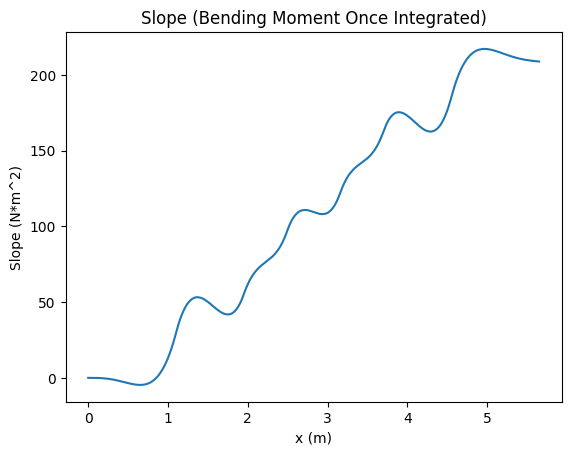

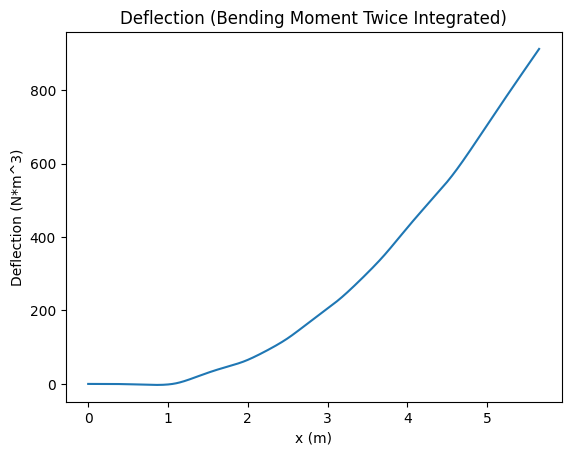

In [123]:
# Deflection for now <?>

# Convert x to m
x = [i / 1000 for i in x]

# Integrate a matplotlib graph
# xList and yList are from matplotlib graph
# C is the integration constant
def integrate(yList, xList, C):
    # The function starts at C
    output = [C]
    for i in range(len(xList) - 1):
        riemannHeight = yList[i+1] + yList[i] / 2
        riemannWidth = xList[i+1] - xList[i]
        output.append(output[i] + (riemannHeight * riemannWidth))
    return output


# Integrate to find slope
slope = integrate(moment, x, 0)

# Plot slope
plt.plot(x,slope)
plt.title("Slope (Bending Moment Once Integrated)")
plt.xlabel('x (m)')
plt.ylabel('Slope (N*m^2)')
plt.show()

# Integrate to find deflection
deflection = integrate(slope, x, 0)

# Plot Deflection
plt.plot(x,deflection)
plt.title("Deflection (Bending Moment Twice Integrated)")
plt.xlabel('x (m)')
plt.ylabel('Deflection (N*m^3)')
plt.show()


In [124]:
print(f"Paddler Positions: `{pad_po}`")
print(f"Paddler Weights: `{[str(x / LLF) + ' kg' for x in pad_weight]}`".replace("'", ""))

# print(f"Waterline (from bottom of canoe): `{waterline} mm`")
# print(f"The angle of the canoe in the water is `{angle} degrees`")

with open('data/Shear_and_Moment_6 Paddlers.csv', 'r') as f:
    print(f"```{f.read()}```")

Paddler Positions: `[1100, 1950, 2495, 4550, 3700, 3155]`
Paddler Weights: `[83.0 kg, 83.0 kg, 83.0 kg, 83.0 kg, 83.0 kg, 83.0 kg]`
```,Value,Station No,Max Width [mm],Max Depth [mm],Station Thickness [mm]
Positive Shear [N],666.855009760035,45,417.20638599999995,355.319046,100.89285700000073
Negative Shear [N],-666.855009760032,11,391.36180950000005,354.6292265,100.89285800000005
Positive Bending Moment [Nm],134.94673884892555,11,391.36180950000005,354.6292265,100.89285800000005
Negative Bending Moment [Nm],-33.71747894359951,41,502.03117499999996,355.9746245,100.89285700000028
Moment at the end [Nm],-3.6487818607284535,56,,,
```
